[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/final/final.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/final/final.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/Danysan1/ai-unibo-nlp-project/tree/main/final/final.ipynb)

# Final project

## Imports and Initial Settings

In [49]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from os import path
from matplotlib import pyplot as plt
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader

In [51]:
# Fix the random state to 42
SEED = 42
labels = ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']

# if a different set of labels is needed, decomment the next lines and select a different subset of labels,
# but always use the variable 'labels' since all the code will use that. If you want to select
# the full set of labels, just comment the next two lines

#suggested_labels = ['Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']
#labels = suggested_labels

In [52]:
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Dataset Download

In [53]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.tsv')
    if not os.path.exists(data_path):
        print(f"Downloading Touché23-ValueEval {suffix} data... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [54]:
data_folder = 'Dataset'

In [55]:
# Training data
training = {'suffix': 'arguments-training', 'url': "https://zenodo.org/record/7550385/files/arguments-training.tsv?download=1"}
labels_training = {'suffix': 'labels-training', 'url': "https://zenodo.org/record/7550385/files/labels-training.tsv?download=1"}
level1_labels_training = {'suffix': 'level1-labels-training', 'url': "https://zenodo.org/record/7550385/files/level1-labels-training.tsv?download=1"}

# Validation data
validation = {'suffix': 'arguments-validation', 'url': "https://zenodo.org/record/7550385/files/arguments-validation.tsv?download=1"}
labels_validation = {'suffix': 'labels-validation', 'url': "https://zenodo.org/record/7550385/files/labels-validation.tsv?download=1"}
level1_labels_validation = {'suffix': 'level1-labels-validation', 'url': "https://zenodo.org/record/7550385/files/level1-labels-validation.tsv?download=1"}

# Test data
test = {'suffix': 'arguments-test', 'url': "https://zenodo.org/record/7550385/files/arguments-test.tsv?download=1"}

to_download = [training, 
                labels_training,
                validation,
                labels_validation]

In [56]:
for data in to_download:
    download_data(data_path=data_folder, url_path=data['url'], suffix=data['suffix'])

## Dataset Loading

In [57]:
def load_touche_dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data = pd.read_csv(path.join(data_folder, filename), sep='\t', header=0, index_col='Argument ID')
        return data

In [58]:
def filter_labels(labels_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of labels (e.g. from labels-training.tsv), this method drops all the columns not contained in the subset list 
    """
    m = labels_df[subset].mask(labels_df[subset] == 0).dropna(how='all').replace(np.NaN, 0)
    return pd.DataFrame(m, dtype=int)

def filter_indexes(data_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of arguments (e.g. from arguments-training.tsv), this method drops all the rows with indexes not contained in the subset list.
        This method is useful after a labels DataFrame has been filtered, because it removes rows that couldn't be classificated
    """
    return data_df.filter(subset, axis='index')

In [59]:
train_labels_df = filter_labels(load_touche_dataset("labels-training.tsv"), subset=labels)
train_df = filter_indexes(load_touche_dataset("arguments-training.tsv"), subset=train_labels_df.index) 
val_labels_df = filter_labels(load_touche_dataset("labels-validation.tsv"), subset=labels)
val_df = filter_indexes(load_touche_dataset("arguments-validation.tsv"), subset=val_labels_df.index)
train_df.head() 

,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [60]:
val_df.head()

,Conclusion,Stance,Premise
Argument ID,,,
A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...
A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...
A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...
A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...


In [61]:
train_labels_df.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [62]:
train_df.describe().drop(index=['top'], axis=1)

,Conclusion,Stance,Premise
count,5392,5392,5392
unique,332,2,5312
freq,114,2898,2


A barplot to describe the representation in the dataset of each argument's category

<BarContainer object of 20 artists>

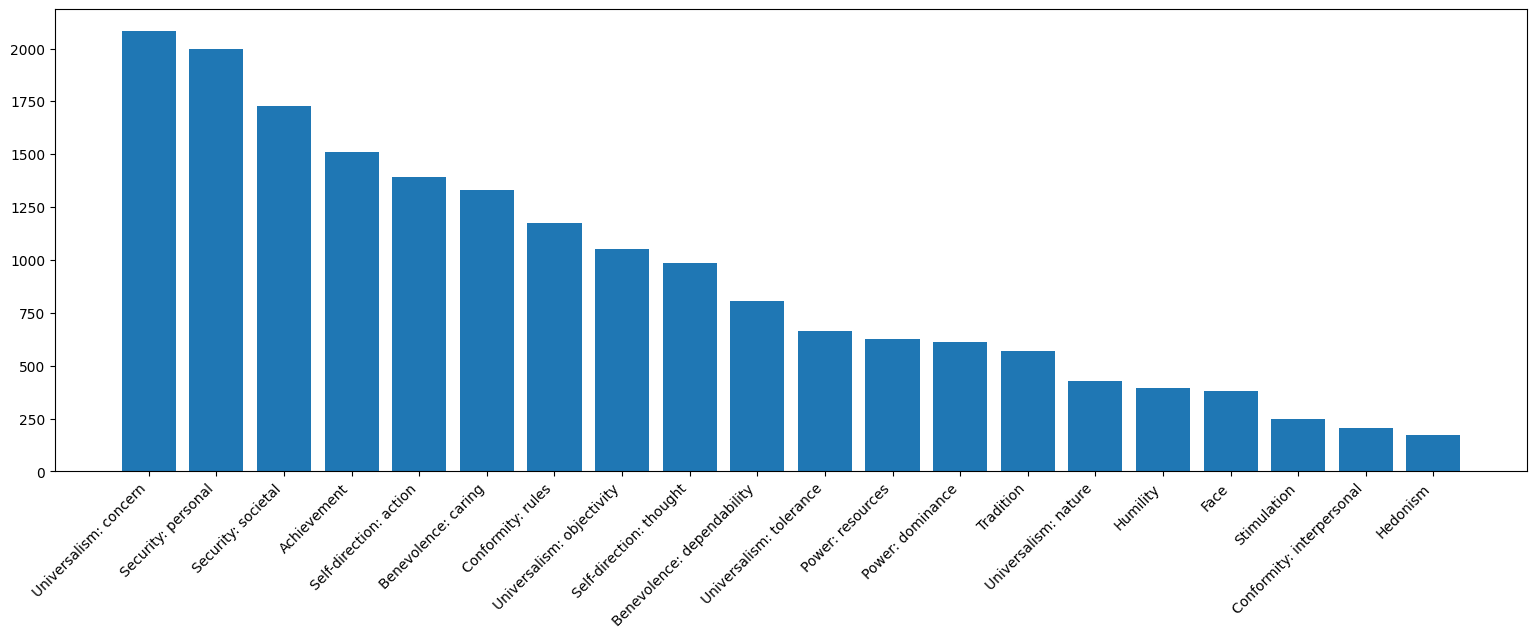

In [63]:
values = train_labels_df.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)

plt.figure(figsize=(19,6))
plt.xticks(rotation=45, ha="right")
plt.bar(x, height=y)

In [64]:
labels_names = train_labels_df.columns.tolist()
labels_names

['Self-direction: thought',
 'Self-direction: action',
 'Stimulation',
 'Hedonism',
 'Achievement',
 'Power: dominance',
 'Power: resources',
 'Face',
 'Security: personal',
 'Security: societal',
 'Tradition',
 'Conformity: rules',
 'Conformity: interpersonal',
 'Humility',
 'Benevolence: caring',
 'Benevolence: dependability',
 'Universalism: concern',
 'Universalism: nature',
 'Universalism: tolerance',
 'Universalism: objectivity']

In [65]:
train_labels_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

## Pytorch Dataset

In [66]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

#Model

In [67]:
#premise = train_df['Premise']
#stance = train_df['Stance']
#conclusion = train_df['Conclusion'] 
num_labels = train_labels_df.shape[1]

In [68]:
#model_checkpoint= 'prajjwal1/bert-tiny'
#model_checkpoint = "distilbert-base-uncased"
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

eos_token  = tokenizer.cls_token_id
sep_token  = tokenizer.sep_token_id

    

In [69]:
#premise , stance, conclusion  --> premise, stance + conclusion
#append the stance to the conclusion by putting a separator between them
sequence_sc = train_df["Stance"].str.cat(train_df["Conclusion"], sep = '[SEP]') # If needed a separator can be passed, for example with sep='[SEP] '
len(sequence_sc)

5392

In [70]:
encodings = tokenizer(list(train_df['Premise']), list(sequence_sc), 
                          padding=True,
                          truncation=True,
                          max_length = 250
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
#label_values = tokenizer(answers,padding=True,truncation=True,max_length = 60)
#labels, labels_mask = label_values['input_ids'], label_values['attention_mask']


#max_length = len(labels[0])

#masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

#add targets to the encodings dictionary
encodings.update({'labels' : torch.FloatTensor(train_labels_df.values)})

length of input_ids: (5392, 173)


In [71]:
len(encodings.items())

4

In [72]:
encodings['labels'][:3]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [73]:
np.array(tokenizer.batch_decode(input_ids[0])).squeeze()

array(['[CLS]', 'we', 'should', 'ban', 'human', 'cl', '##oning', 'as',
       'it', 'will', 'only', 'cause', 'huge', 'issues', 'when', 'you',
       'have', 'a', 'bunch', 'of', 'the', 'same', 'humans', 'running',
       'around', 'all', 'acting', 'the', 'same', '.', '[SEP]', 'in',
       'favor', 'of', '[SEP]', 'we', 'should', 'ban', 'human', 'cl',
       '##oning', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '

In [74]:
lr = 5e-5
batch_size = 4
epochs = 5

In [75]:
train_dataset = CreateDataset(encodings)
#create training dataloader
data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )

In [76]:
from torch.nn.modules import dropout
from transformers import DistilBertModel, BertModel
import torch.nn as nn
class CustomBERTModel(nn.Module):
    def __init__(self,checkpoint,num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_labels = num_labels
          #self.model = model = DistilBertModel.from_pretrained(checkpoint)
          self.model = model = BertModel.from_pretrained(checkpoint)
          ### New layers:
          #self.l1 = dropout(0.1)
          self.l2 = nn.Linear(self.model.config.hidden_size, 256)
          self.classifier = nn.Linear(256, num_labels) ## num_labels are the number of classes 

    def forward(self, input_ids, attention_mask):
          output = self.model(
               input_ids, 
               attention_mask=attention_mask)
          sequence_output = output[0]
          #the pooler output contains the information 
          pooler_output = output.pooler_output
          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          #x = self.linear1(sequence_output[:,0,:].view(-1,768)) ## extract the 1st token's embeddings CLS
         # x = self.l1(pooler_output)
          x = self.l2(pooler_output)
          x = self.classifier(x)
          output = torch.sigmoid(x)
          return output

In [77]:
model = CustomBERTModel(model_checkpoint, num_labels) 
model.to(device)
#binary cross entropy
criterion = nn.BCELoss()
#Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
model.train()
avg_losses = []
for epoch in range(epochs):
    loss_score = []
    loop = tqdm(data_loader_train)
    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['labels'].to(device)
        logits = model(input_ids,
                              attention_mask=attention_mask)                
        
        #loss = outputs[0]
        loss = criterion(logits, targets)
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    avg_loss = np.mean(loss_score)
    avg_losses.append(avg_loss)
    print(f"\naverage_loss per epoch {epoch+1}: {avg_loss}")

  0%|          | 0/1348 [00:00<?, ?it/s]<ipython-input-66-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████| 1348/1348 [03:41<00:00,  6.09it/s, loss=0.247]



average_loss per epoch 1: 0.3774249490671059


Epoch 1: 100%|██████████| 1348/1348 [03:35<00:00,  6.24it/s, loss=0.448]



average_loss per epoch 2: 0.3231924443066297


Epoch 2: 100%|██████████| 1348/1348 [03:35<00:00,  6.25it/s, loss=0.344]



average_loss per epoch 3: 0.2805718992137591


Epoch 3: 100%|██████████| 1348/1348 [03:35<00:00,  6.26it/s, loss=0.288]



average_loss per epoch 4: 0.23899954052238506


Epoch 4: 100%|██████████| 1348/1348 [03:35<00:00,  6.26it/s, loss=0.237]


average_loss per epoch 5: 0.19908415538311358


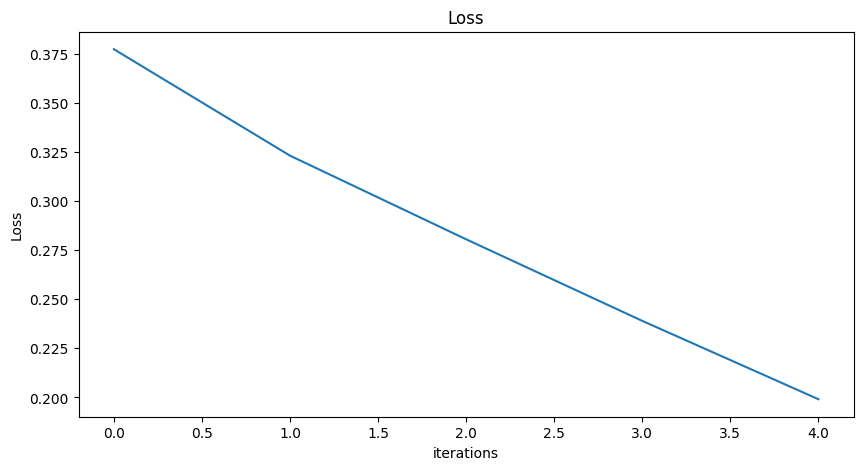

In [95]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(avg_losses,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [80]:
def encode(tokenizer, df, labels):
  sequence_sc = df["Stance"].str.cat(df["Conclusion"], sep = '[SEP]') # If needed a separator can be passed, for example with sep='[SEP] '
  encodings = tokenizer(list(df['Premise']), list(sequence_sc), 
                          padding=True,
                          truncation=True,
                          max_length = 300
                          )
  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
  encodings.update({'labels' : torch.FloatTensor(labels.values)})
  encodings.pop('token_type_ids')
  return encodings

test_encodings = encode(tokenizer,val_df, val_labels_df)


In [81]:
val_dataset = CreateDataset(test_encodings)
#create training dataloader
batch_size = 4
data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle = False
                                        )

In [82]:
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

3385

In [83]:
!nvidia-smi

Sat Apr  1 18:12:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    42W /  70W |   3121MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
len(test_encodings)
test_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [85]:
average_loss = []
predictions = []
model.eval()
model.to(device)
first = True
loop = tqdm(data_loader_val)
with torch.no_grad():
  for batch in loop:
    target = batch['labels'].to(device)
    prediction = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
    predictions.append(prediction)
    loss = criterion(prediction,target)
    average_loss.append(loss.item())
  
loss = np.mean(average_loss)
print(f"\naverage loss on val set: {loss}")

  0%|          | 0/474 [00:00<?, ?it/s]<ipython-input-66-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 474/474 [00:20<00:00, 23.44it/s]


average loss on val set: 0.39576216494735283


In [86]:
predicitons = torch.stack(predictions).detach().cpu()
len(predictions)
np.shape(predicitons)

torch.Size([474, 4, 20])

In [87]:
#reshape
y_p = []
for idx in range(len(predictions)):
  for b in range(batch_size):
    y_p.append(predictions[idx][b])

In [88]:
np.shape(torch.stack(y_p).detach().cpu())

torch.Size([1896, 20])

In [89]:
threshold = 0.5
y_pred=[]
for sample in y_p:
  y_pred.append([1 if i>=threshold else 0 for i in sample])
y_pred = np.array(y_pred)
y_pred.shape

(1896, 20)

In [90]:
"""
threshold = 0.5
y_pred=[]
for sample in predictions:
  y_pred.append([1 if i>=threshold else 0 for i in sample.squeeze(dim=0)])
y_pred = np.array(y_pred)
y_pred.shape
"""

'\nthreshold = 0.5\ny_pred=[]\nfor sample in predictions:\n  y_pred.append([1 if i>=threshold else 0 for i in sample.squeeze(dim=0)])\ny_pred = np.array(y_pred)\ny_pred.shape\n'

In [91]:
y_true = np.array(val_labels_df)
y_true[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]])

In [92]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_true, y_pred)

0.07858649789029536

In [93]:
print(classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0))

                            precision    recall  f1-score   support

   Self-direction: thought       0.57      0.40      0.47       251
    Self-direction: action       0.68      0.30      0.42       496
               Stimulation       0.42      0.13      0.20       138
                  Hedonism       0.54      0.30      0.39       103
               Achievement       0.68      0.63      0.65       575
          Power: dominance       0.52      0.15      0.23       164
          Power: resources       0.47      0.41      0.44       132
                      Face       0.29      0.05      0.09       130
        Security: personal       0.69      0.79      0.74       759
        Security: societal       0.57      0.64      0.61       488
                 Tradition       0.60      0.37      0.46       172
         Conformity: rules       0.55      0.36      0.44       455
 Conformity: interpersonal       0.27      0.07      0.11        60
                  Humility       0.22      0.02

In [94]:
"""
x = val_df[:1]
target = val_labels_df[:1]
threshold = 0.5
print('Predictions:')
for label, pred in zip(labels_names, prediction[0]):
  if pred < threshold:
    continue
  print(f"{label}: {pred}")


threshold = 1.
print('True values:')
for label, pred in zip(labels_names, target.values[0]):
  if pred < threshold:
    continue
  print(f"{label}: {pred}")
"""

'\nx = val_df[:1]\ntarget = val_labels_df[:1]\nthreshold = 0.5\nprint(\'Predictions:\')\nfor label, pred in zip(labels_names, prediction[0]):\n  if pred < threshold:\n    continue\n  print(f"{label}: {pred}")\n\n\nthreshold = 1.\nprint(\'True values:\')\nfor label, pred in zip(labels_names, target.values[0]):\n  if pred < threshold:\n    continue\n  print(f"{label}: {pred}")\n'